# ML4L Workflow

The `ML4L` project is trying to use ML techniques to learn the land surface temperature (LST). 

This notebook attempts to track each stage of the project, from the raw data to the output plots, to enable reproducible research.

The only inputs a user needs to recreate this work is the raw data from ECMWF.

---
# Table of contents
1. [Raw Data](#rawdata) <br>

    1.1 [ERA5 data](#rawdataERA5) <br>
...1.1.1 [Processing ERA5 data](#rawdataERA5processing) <br>
    1.2 [MODIS data](#rawdataMODIS) <br>
    1.3 [Data Overview](#rawdataOverview) <br>
    
2. [Joining data](#joiningdata) <br>
3. [Training a Model](#trainingmodel) <br>
4. [Analysis and Visualisation](#analysis) <br>

    4.1 [Compare Models: V15 vs. V20](#analysiscompare) <br>


---

# 1. Raw Data <a name="rawdata"></a>
Any ML project needs data.

We can split this into two main categories: inputs and outputs.

Inputs are the features that go into our ML model. Outputs are the things we are trying to learn.

For this project:

* Inputs: ERA5 data

* Outputs: MODIS data

## 1.1 ERA5 Data <a name="rawdataERA5"></a>

We have a few different raw sources of ERA5 data provided by ECMWF.


These are:

* a) ERA_sfc
* b) ERA_skin
* c) ERA_skt
* d) climateV15
* e) climateV20
* f) Lakes and wetlands


Lets have a quick look at what these are like:



**a)** ERA_sfc. 3 years of data (2018-2020), hourly grain. Features: `sp, msl, 10u, 10v, 2t.` 

In [5]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2018_01.grib | head -10

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           sp           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           msl          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           10u          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           10v          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           2t           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           sp           grid_

**b)** ERA_skin. 10 years of data (2010-2020), hourly grain. Features: `aluvp,aluvd,alnip ,alnid,cl,cvl,cvh,istl1,istl2,slt,sdfor,z,sd,sdor,isor,anor,slor
2d,lsm,fal`



In [4]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib | head -25

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           aluvp        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           aluvd        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           alnip        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           alnid        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           cl           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           cvl         

**c)** ERA_skt. 3 years of data (2018-2020), hourly grain. Features: `skt`

In [14]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt/skt_unstructured_2018_01.grib | head -5

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt/skt_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  


**d)** climateV15. Some additional constant in time features. Overlaps with some data we already have. Note there also exist `clake` and `lsmoro`, which describe features we have above.

In [11]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/sfc 

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/sfc
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20131129     an           reduced_gg   0            surface      0            anor         grid_simple 
2            ecmf         20131129     an           reduced_gg   0            surface      0            isor         grid_simple 
2            ecmf         20131129     an           reduced_gg   0            surface      0            slor         grid_simple 
2            ecmf         20131129     an           reduced_gg   0            surface      0            sdor         grid_simple 
1            ecmf         19960101     not_found    reduced_gg   0            surface      0            sr           grid_simple 
1            ecmf         19960101     not_found    reduced_gg   0            surface      0            lsrh  

**e)** climateV15. More up to date (version 20) fields. Overlaps with some data we already have:

In [13]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/lsmoro
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/sfc

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20110131     af           reduced_gg   0            surface      0            cl           grid_simple 
1 of 1 messages in /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake

1 of 1 total messages in 1 files
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/lsmoro
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20210222     an           reduced_gg   0            surface      0            lsm          grid_simple 
2            ecmf         20210222     an           reduced_gg   0            surface      

**f)** Lakes and wetlands. Monthly values of `cldiff`. Multiple sources: `'COPERNICUS', 'CAMA','ORCHIDEE','monthlyWetlandAndSeasonalWater_minusRiceAllCorrected_waterConsistent','CL_ECMWFAndJRChistory'`

In [96]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusClimate/COPERNICUS/wetlandf


/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusClimate/COPERNICUS/wetlandf
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         99990115     an           reduced_gg   0            surface      0            cldiff       grid_simple 
2            ecmf         99990215     an           reduced_gg   0            surface      0            cldiff       grid_simple 
2            ecmf         99990315     an           reduced_gg   0            surface      0            cldiff       grid_simple 
2            ecmf         99990415     an           reduced_gg   0            surface      0            cldiff       grid_simple 
2            ecmf         99990515     an           reduced_gg   0            surface      0            cldiff       grid_simple 
2            ecmf         99990615     an           reduced_gg   0            surface      0            cldiff    

**g)** Lakes and wetlands, constant. Constant field for lake data.

In [97]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusClimate/yearlyCL/clake

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusClimate/yearlyCL/clake
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         99990615     an           reduced_gg   0            surface      0            vegdiff      grid_simple 
1 of 1 messages in /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusClimate/yearlyCL/clake

1 of 1 total messages in 1 files


## 1.1.1 Processing ERA5 Data <a name="rawdataERA5processing"></a>


Given all this data in disparate files, it will be useful to bring it all together in a consistent, easily usable format.

There is some overlap between files, with some files holding the same features.

There is also some degneracy in that we are needlessly holding values of features which are constant in time

**Which data is constant in time?**

In [27]:
import xarray as xr
import numpy as np
import pandas as pd

example_ERA_sfc_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2018_01.grib'
example_ERA_skin_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib'

def check_if_variables_are_constant(ds): 
    """For all the variables in this ds, are they constant in time for each grid point?"""
    
    #Get all variables/features
    all_variables = list(ds.keys())

    names = []
    variations = []
    for v in all_variables:
    
        a = ds[v].values
        #a == a[0,:] compares each value to the corresponding value in the first row
        #A column shares a common value if all the values in that column are True
        is_constant = all(np.all(a == a[0,:], axis = 0))
        
        
        print (v,is_constant)
        names.extend([v])
        variations.extend([is_constant])
        

In [28]:
ds_sfc = xr.open_dataset(example_ERA_sfc_file,engine='cfgrib',backend_kwargs={'indexpath': ''} )
check_if_variables_are_constant(ds_sfc)

#Surface skin values. Filter out istl1,2 else errors.
ds_skin = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_skin)

sp False
msl False
u10 False
v10 False
t2m False
aluvp False
aluvd False
alnip False
alnid False
cl True
cvl True
cvh True
slt True
sdfor True
z True
sd False
sdor True
isor True
anor True
slor True
d2m False
lsm True
fal False


In [34]:
#Now deal with istl1,2 individually
ds_istl1 = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'shortName': 'istl1'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_istl1)

ds_istl2 = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'shortName': 'istl2'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_istl2)


istl1 False
istl2 False


We have just demonstrated a month of data here, but it is straightforward to extend to multiple months and the conclusions are unchanged.

All variables in `ERA_sfc` are time variable, as is `ERA_skt`.

In `ERA_skin`:

* Time Variable: `aluvp,aluvd,alnip,alnid,istl1,istl2,sd,2d,fal`
* Time Constant: `cl,cvl,cvh,slt,sdfor,z,sdor,isor,anor,slor,lsm`
---


With the features which are (not)constant in time identified we need to take the following steps:

For each month: 
* Extract the time variable features from ERA skin: `aluvp,aluvd,alnip,alnid,istl1,istl2,sd,2d,fal`
* Merge the time variable ERA skin, ERA surface and ERA skt into a single 'time variable' file.

This is done in `scripts/process_time_variable_data.py`.
    
For one month:
* Extract the constant time features from ERA skin, that are not covered in climateV15, climateV20: `slt,sdfor`
* Bring together with the climateV15,climateV20 and yearlyCL (`vegdiff`) data.

This is done in `scripts/process_time_constant_data.py`.

The final outputs of ERA data are then

* `ERA_time_variable` * nmonths. GRIB format. `processed_data/ERA_timevariable`
* `ERA_constant_V15` * 1. NetCDF format. `processed_data/ERA_timeconsant`
* `ERA_constant_V20` * 1. NetCDF format. `processed_data/ERA_timeconsant`
*  Monthly 'bonus' data `raw/BonusClimate/`, NOT `yearlyCL`

The complete list of features is:

In [134]:
feature_names = ['sp', 'msl', 'u10', 'v10', 't2m',                                   # ERA_sfc, Time Variable
            'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m','fal', # ERA_skin, Time Variable
            'skt',                                                                   # ERA skt, Time Variable
            'lsm',  'slt', 'sdfor','lsrh', 'cvh',  'z', 'isor', 'sdor', 'cvl','cl','anor', 'slor', 'sr', 'tvh', 'tvl' #climatev15,v20 constant
            'vegdiff',                                                               #Bonus data
            'COPERNICUS/', 
            'CAMA/',
            'ORCHIDEE/', 
             'monthlyWetlandAndSeasonalWater_minusRiceAllCorrected_waterConsistent/',
             'CL_ECMWFAndJRChistory/'
            ]

import requests
import pandas as pd

r = requests.get("https://apps.ecmwf.int/codes/grib/json/").json()['parameters']

def param_name(x,r):
    try:
        d = next(item for item in r if item["param_shortName"] == x)
        name = d['param_name']
        units = d['units_name']
    except:
        #maybe naming convention is different
        name = 'Null'
        units = 'Null'
    
    return f'{x}: {name} : {units}'


for i in feature_names:
    print(param_name(i,r))

sp: Wind speed (SP) : m s**-1
msl: Mean sea level pressure : Pa
u10: Null : Null
v10: Null : Null
t2m: Null : Null
aluvp: UV visible albedo for direct radiation : (0 - 1)
aluvd: UV visible albedo for diffuse radiation : (0 - 1)
alnip: Near IR albedo for direct radiation : (0 - 1)
alnid: Near IR albedo for diffuse radiation : (0 - 1)
istl1: Ice temperature layer 1 : K
istl2: Ice temperature layer 2 : K
sd: Snow depth water equivalent : kg m**-2
d2m: Null : Null
fal: Forecast albedo : (0 - 1)
skt: Skin temperature : K
lsm: Land-sea mask : (0 - 1)
slt: Soil type : ~
sdfor: Standard deviation of filtered subgrid orography : m
lsrh: Logarithm of surface roughness length for heat : ~
cvh: High vegetation cover : (0 - 1)
z: Geopotential : m**2 s**-2
isor: Anisotropy of sub-gridscale orography : ~
sdor: Standard deviation of orography : m
cvl: Low vegetation cover : (0 - 1)
cl: Lake cover : (0 - 1)
anor: Angle of sub-gridscale orography : radians
slor: Slope of sub-gridscale orography : ~
sr: 

Note there could be some errors in these definitions. For instance, `sp` is surface pressure according to [ECMMWF param database](https://apps.ecmwf.int/codes/grib/param-db/), but the json request returns it as wind speed...? Nulls occur when the feature names we are using don't match with those in database.

## 1.2 MODIS Data <a name="rawdataMODIS"></a>

The MODIS data requires less (or rather no!) processing than the ERA5 data.

Daily `.tiff` files are found at `/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/` and are easy to load and process


## 1.3 Data Overview <a name="rawdataOverview"></a>

It is useful for the intution to have a quick look at each of our data sources: 

* ERA5 time variable:

In [46]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_0.grib'
ERA5_timevariable = xr.open_dataset(f,engine='cfgrib',backend_kwargs={'indexpath': ''} )
display(ERA5_timevariable)

<xarray.Dataset>
Dimensions:              (time: 744, values: 542080)
Coordinates:
    number               int64 ...
  * time                 (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:0...
    step                 timedelta64[ns] ...
    surface              float64 ...
    latitude             (values) float64 ...
    longitude            (values) float64 ...
    valid_time           (time) datetime64[ns] ...
    depthBelowLandLayer  float64 ...
Dimensions without coordinates: values
Data variables: (12/15)
    sp                   (time, values) float32 ...
    msl                  (time, values) float32 ...
    u10                  (time, values) float32 ...
    v10                  (time, values) float32 ...
    t2m                  (time, values) float32 ...
    aluvp                (time, values) float32 ...
    ...                   ...
    istl1                (time, values) float32 ...
    istl2                (time, values) float32 ...
    sd                   (time, values) float32 ...
    d2m                  (time, values) float32 ...
    fal                  (time, values) float32 ...
    skt                  (time, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-04-10T15:29 GRIB to CDM+CF via cfgrib-0.9.1...

* ERA5 time constant, v15 and v20:

In [47]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timeconstant/ERA_constants_v15.nc'
ERA5_timevariable = xr.open_dataset(f)
display(ERA5_timevariable)

<xarray.Dataset>
Dimensions:     (time: 1, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-01-01
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Data variables: (12/15)
    slt         (time, values) float32 ...
    sdfor       (time, values) float32 ...
    lsrh        (values) float32 ...
    cvh         (values) float32 ...
    lsm         (values) float32 ...
    z           (values) float32 ...
    ...          ...
    cl          (values) float32 ...
    anor        (values) float32 ...
    slor        (values) float32 ...
    sr          (values) float32 ...
    tvh         (values) float32 ...
    tvl         (values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-04-10T13:00 GRIB to CDM+CF via cfgrib-0.9.1...

* MODIS

In [48]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/aquaDay_errorGTE03K_04km_2018-01-01.tif'
MODIS_data = xr.open_dataarray(f,engine="rasterio")
display(MODIS_data)

<xarray.DataArray 'band_data' (band: 1, y: 5400, x: 10800)>
[58320000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 180.0 180.0
  * y            (y) float64 89.98 89.95 89.92 89.88 ... -89.92 -89.95 -89.98
    spatial_ref  int64 ...
Attributes:
    long_name:  LST_Day_1km

---
# 2. Joining Data <a name="joiningdata"></a>


We have our inputs `ERA` and our outputs `MODIS` in a nice clean form.

We now need to join these two data sources in both space and time.

What this means is, for a bunch of ERA features at time `t` and grid point `x` what is the corresponding real-world observation provided by MODIS?

This is implemented in `scripts/join_MODIS_with_ERA.py`

The general method is as follows:

* Load a day of MODIS data

* Apply latitude bounds (|lat| < 70), calculate the 'absolute' UTC from the longitude and filter this data to an hour. 

* Load a month of ERA data

* Filter this data to an hour. Apply lsm > 0.5. 

* Use `faiss_knn()` to join ERA_hour + MODIS_hour in space. `faiss_knn()` implements a GPU accelerated k nearest neighbours algo. See https://github.com/facebookresearch/faiss . 
    * For each MODIS data point, find the nearest ERA grid point, where nearness is an L2 (squared) norm on the lat/long coordinates.
    * Filter out those matches where the Haversine distance is > 50 km
    * We now have multiple MODIS data points for each ERA grid point. Groupby and take an average


Monthly joined data is written to `processed_data/joined_data`.

Also note:

* Matching 1 month of data takes ~17 mins for one version. For two versions, ~30mins - i.e. sub linear scaling. There may be a more efficient way to do this - for now we will settle with this as "good enough", as the matching only needs to be done once. In practice, matching 3 years of data, both versions takes ~12-14 hours.

* During the matching process, we also carry all the ERA features, both constant and time variable. This is not strinctly necessary, it could be more efficient to just carry the $(\bar{x},t)$ and bring the features in later, but in practice this approach works well.

* We have two sets of outputs: `processed_data/joined_data/v15/`, `processed_data/joined_data/v20`. This is necessary since a) the `lsm` values in v15 and v20 are different and b) those grid points which are lsm > 0.5 (the filtering condition we use) are different e.g.

In [92]:
import xarray as xr
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'

#v15
v15 = root +'processed_data/ERA_timeconstant/ERA_constants_v15.nc'
ds15 = xr.open_dataset(v15) 

#v20
v20 = root +'processed_data/ERA_timeconstant/ERA_constants_v20.nc'
ds20 = xr.open_dataset(v20)

#Land filters
land_filter_15 = (ds15.lsm > 0.5)
land_filter_20 = (ds20.lsm > 0.5)

#are they the same?
land_filter_15.equals(land_filter_20)

False




With `scripts/join_MODIS_with_ERA.py` having completed successfully, we can can visualise the output of the matching by plotting hourly snapshots of data as follows:

In [177]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
example_month = pd.read_pickle('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/v15/matched_0.pkl')

def plot_map(df,x,y,q): #slow plotting function using geopandas
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    
    plt.show()

2018-01-01T10:00:00.000000000


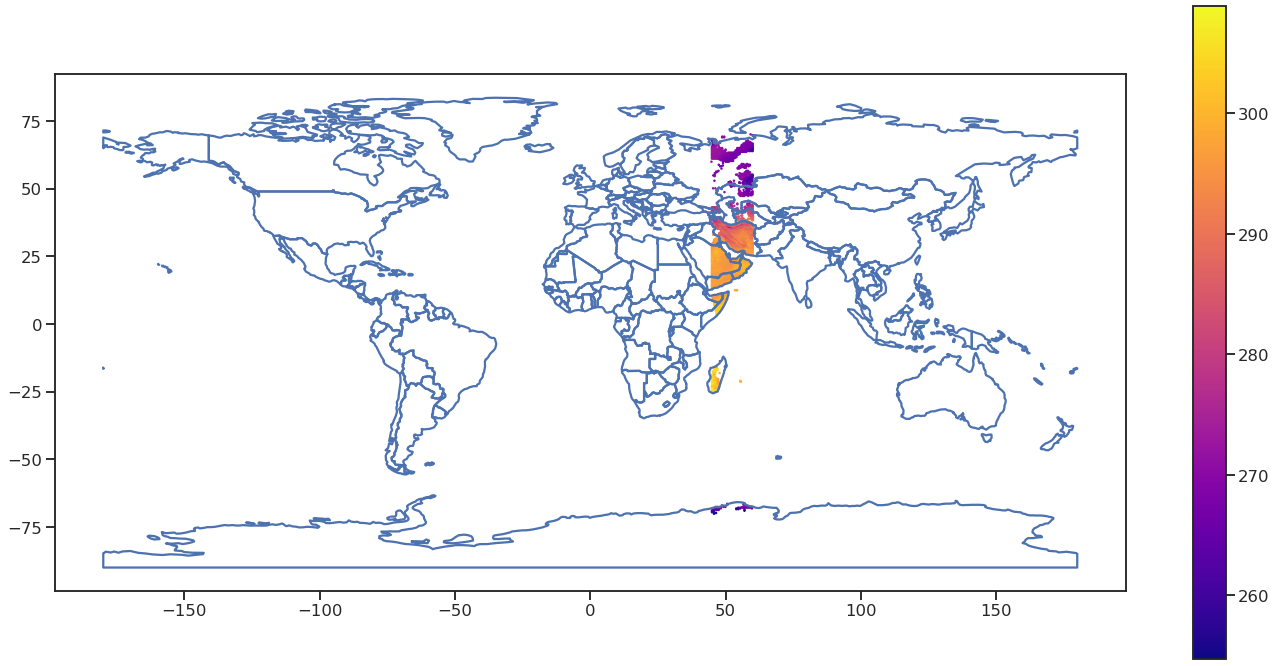

2018-01-01T11:00:00.000000000


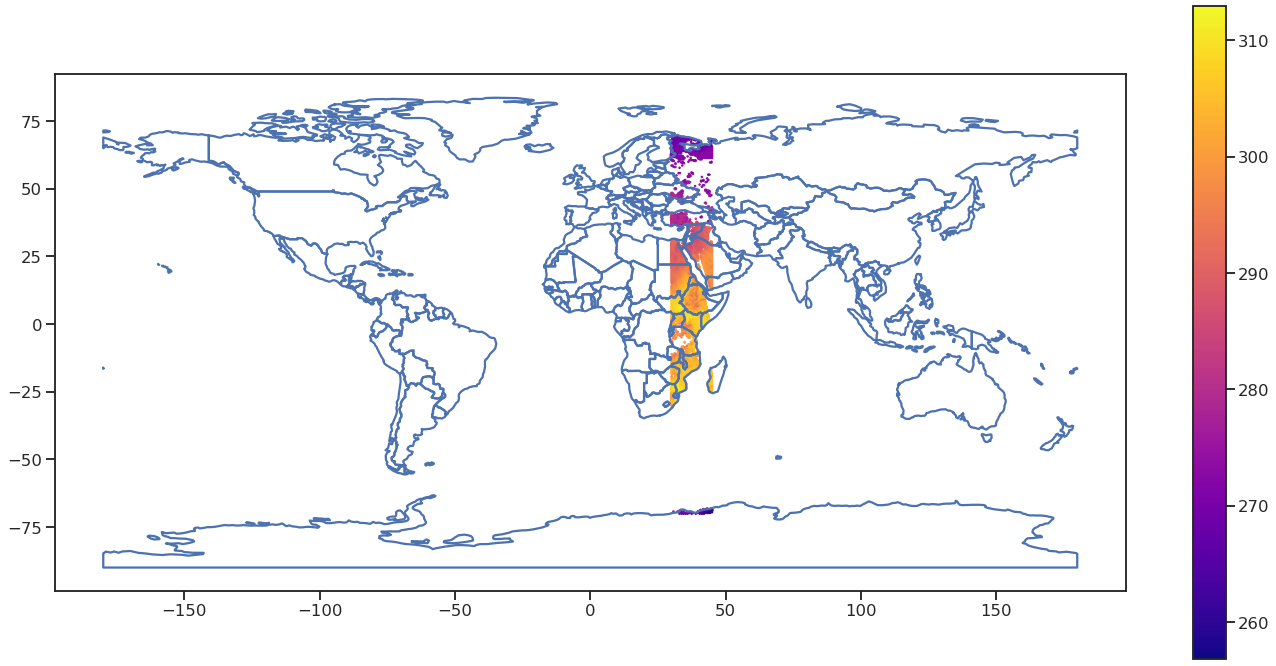

2018-01-01T12:00:00.000000000


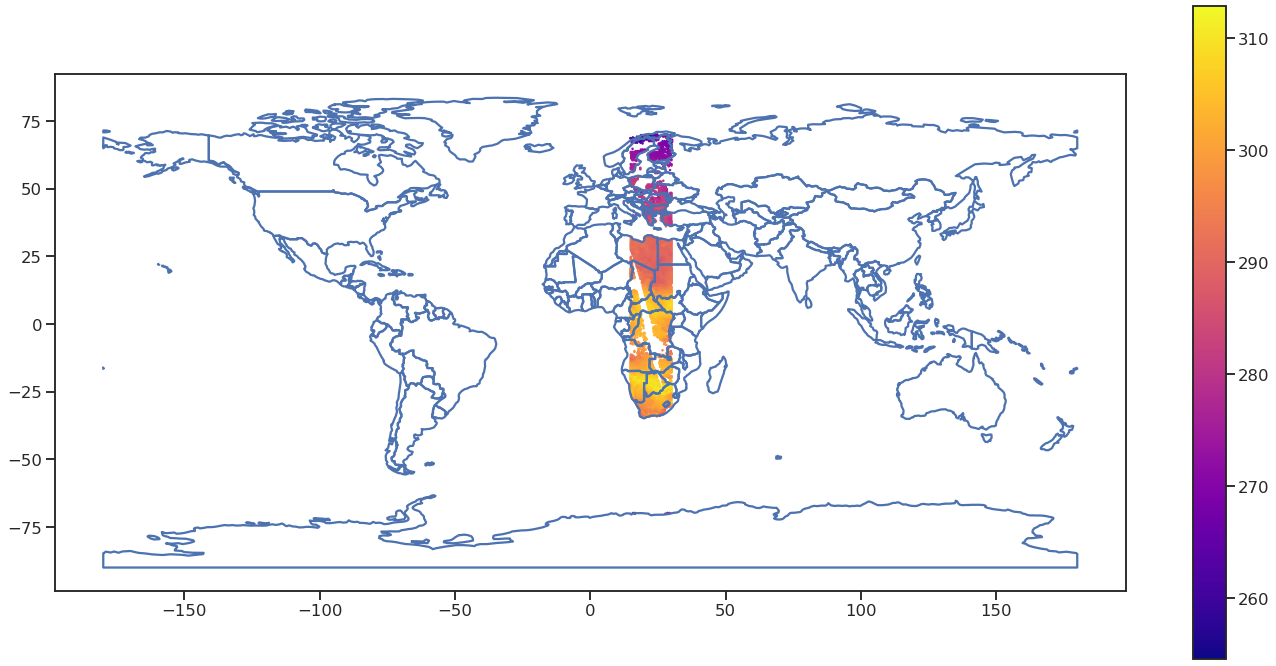

2018-01-01T13:00:00.000000000


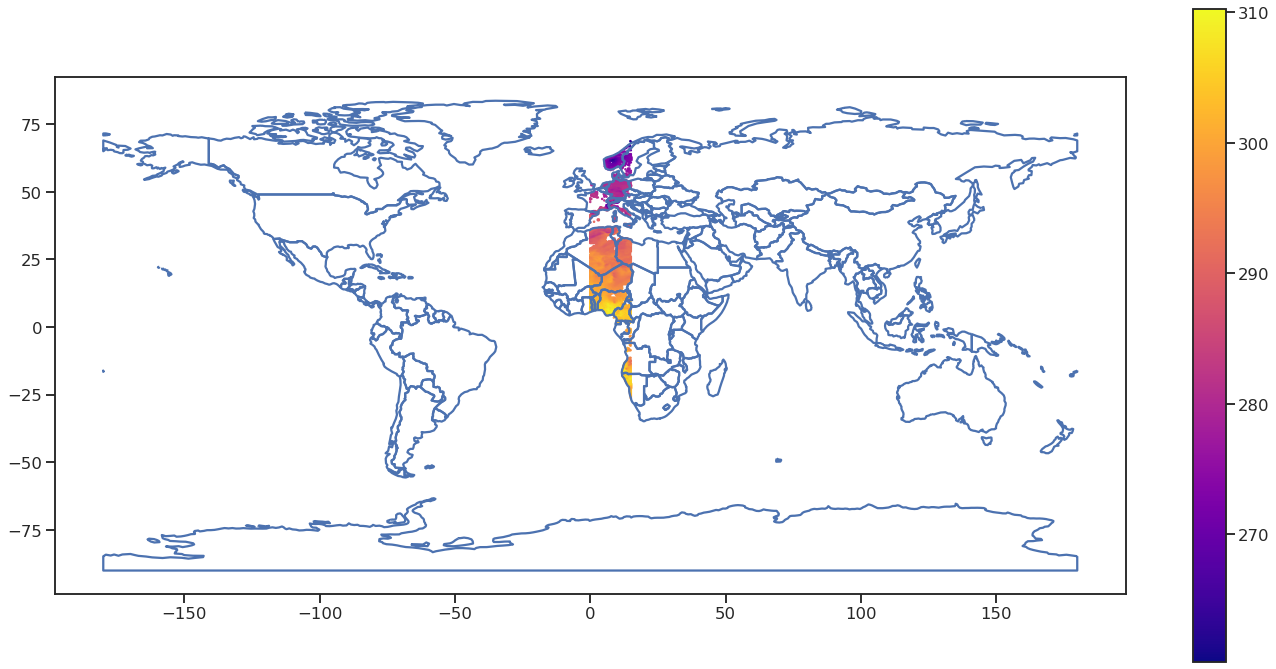

2018-01-01T14:00:00.000000000


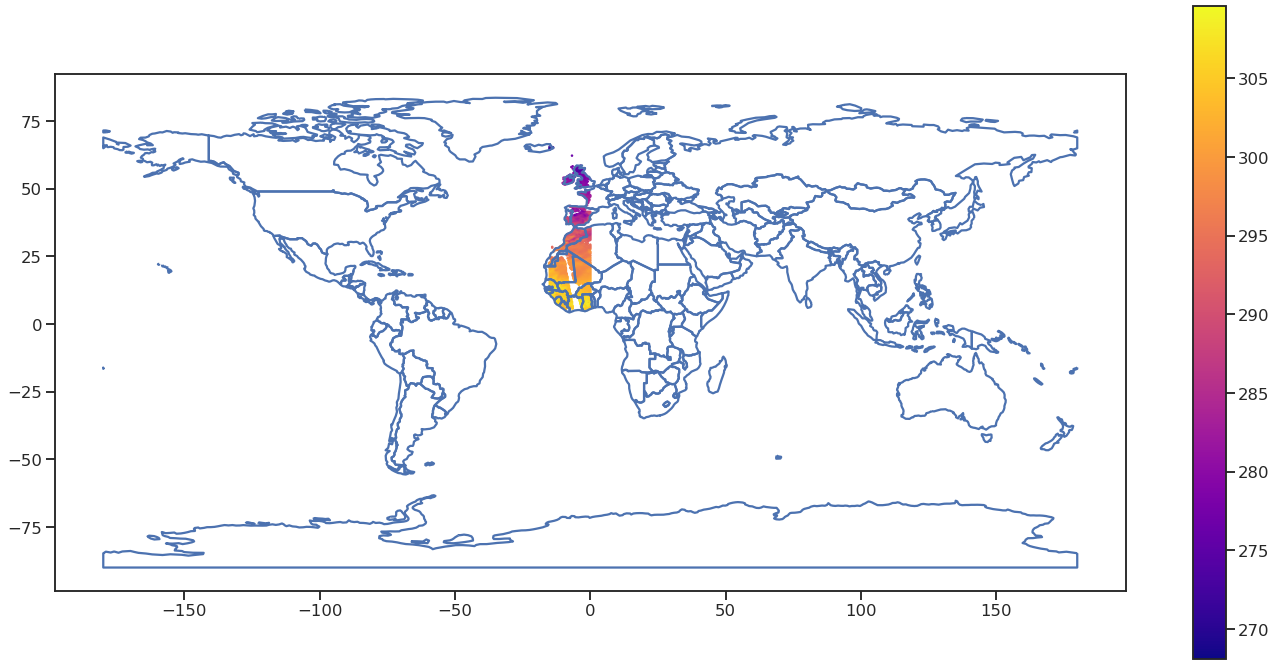

2018-01-01T15:00:00.000000000


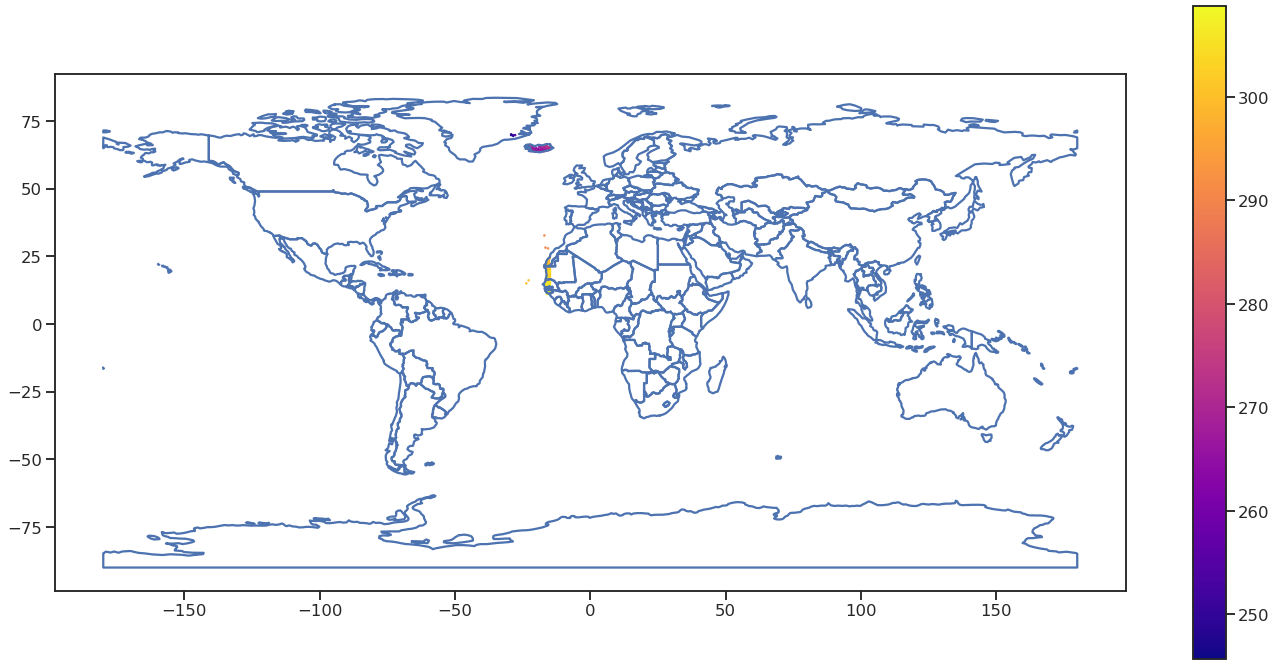

2018-01-01T16:00:00.000000000


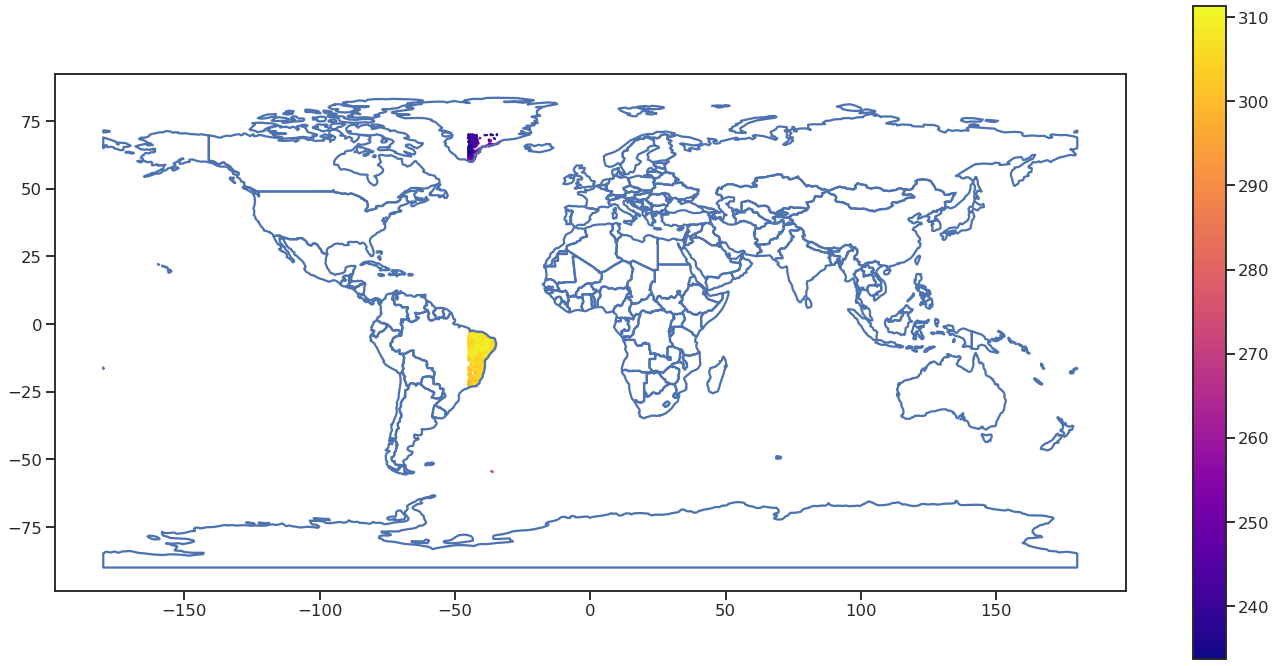

2018-01-01T17:00:00.000000000


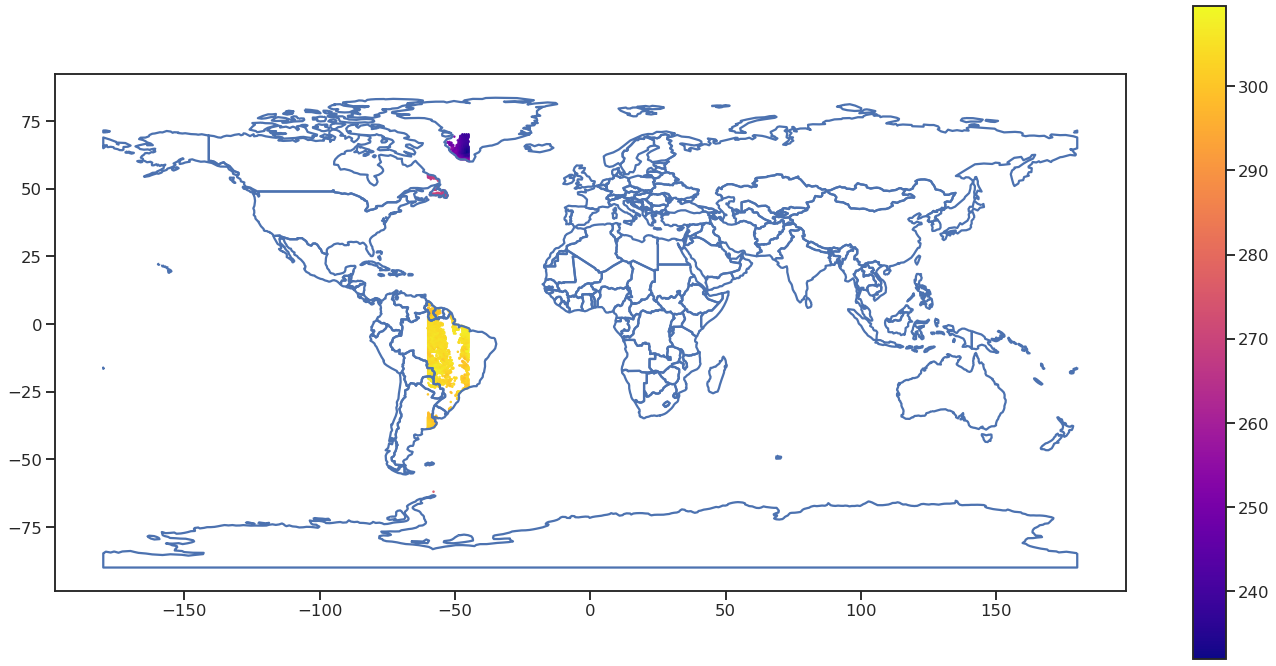

In [178]:
times = example_month.time.unique()
for t in times[8:16]: #for a selection of hours
    print(t)
    df_hour = example_month.query(f'time == "{t}"')
    plot_map(df_hour,'longitude_ERA', 'latitude_ERA', 't2m')


And we can also look at a 24 hour period of data:

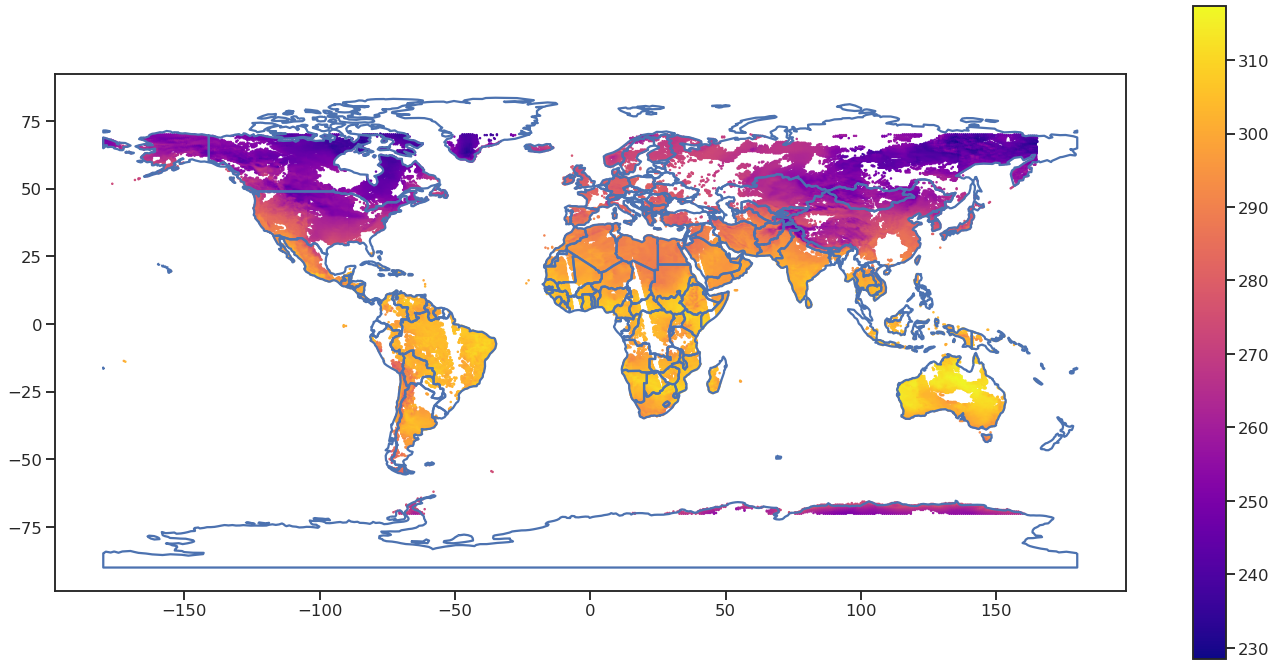

In [179]:
start_time = times[0]
end_time = times[24]
df_day = example_month.query(f'time > "{start_time}" & time < "{end_time}"')
plot_map(df_day,'longitude_ERA', 'latitude_ERA', 't2m')


Since the monthly files are not too large (~500 MB), it is useful to bring them all together into a single joined data file: `scripts/unify_monthly_matches.py`. 


This provides two files which we will use for training/testing our model: `v15/all_months.h5` , `v20/all_months.h5`

---


# 3. Training a Model <a name="trainingmodel"></a>


Given our single dataframe relating features to outputs we are now in a position to train a model.

We use 2018 as training data, 2020 as test data, holding 2019 as a validation set.

A model is trained and then makes predictions in `scripts/train_and_predict.py`

The model uses [Tensorflow](https://www.tensorflow.org/) to construct a sequential, tapered NN with 1 hidden layer. 

We output:
* Trained model, including the history 
* The model predictions, `predictions.pkl`
* Some useful meta data `meta.txt`

---

# 4. Analysis and Visualisation <a name="analysis"></a>


With a model trained we can plot:

* Training history
* Distribution of prediction errors (and compare errors with ERA SKT)
* Map of prediction errors

For example:

In [169]:

import matplotlib.colors as mc
import matplotlib.colorbar as cb 
import matplotlib.pyplot as plt
import json
import seaborn as sns

def plot_training_history(path,logscale,jump_n_epochs):
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)

        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        

        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        try:
            validation_loss = d['val_loss'][i:]
            plt.plot(epochs,validation_loss, label='validation loss')
        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')

def load_predictions(path, print_errors):

    df = pd.read_pickle(path+'predictions.pkl')

    #Create some new columns for the errors
    df['error_ERA'] = df.MODIS_LST - df.skt
    df['error_ERA_abs'] = abs(df.MODIS_LST - df.skt)

    df['error_NN'] = df.MODIS_LST - df.predictions
    df['error_NN_abs'] = abs(df.MODIS_LST - df.predictions)

    df['NN_vs_ERA'] = df['error_NN_abs'] - df['error_ERA_abs']

    #Surface some useful numbers
    
    if print_errors:
        print('Absolute error:')
        print('--------------------------------')
        print("NN model: Mean error, Median error, Std deviation:",df.error_NN_abs.mean(), df.error_NN_abs.median(),df.error_NN_abs.std())
        print("ERA5: Mean error, Median error, Std deviation    :", df.error_ERA_abs.mean(), df.error_ERA_abs.median(),df.error_ERA_abs.std())

        print('Biased error:')
        print('--------------------------------')
        print("NN model: Mean bias, Median bia, Std deviation:",df.error_NN.mean(), df.error_NN.median(),df.error_NN.std())
        print("ERA5: Mean bias, Median bias, Std deviation::    ", df.error_ERA.mean(), df.error_ERA.median(),df.error_ERA.std())


    return df
    
def plot_error_map(df,z,vmin,vmax,cmap,scale,title):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    if scale == 'log':
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)
        
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(title)
    #fig.tight_layout()
    
    plt.show()

# def plot_distribution(d,bins):
 
   
#     #Setup plot env
#     h,w = 20,20

#     sns.set_theme(context='talk', 
#                   style='ticks', 
#                   palette='deep',
#                   rc={'figure.figsize':(h,w)}
#                   )

    
#     #Figure
#     fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    
#     #Plot    
#     p1 = sns.histplot(data=d, x="error_ERA", ax=ax1,stat='probability', bins=bins,alpha=0.7,color='C0',label='ERA')
#     p2 = sns.histplot(data=d, x="error_NN", ax=ax1,stat='probability', bins=bins,alpha=0.7,color='C1',label='NN')


    

    
#     # Config
#     ax1.set_xlabel('Error', fontsize = 20)
#     ax1.legend().set_title(None)
    
    
#     ax1.axvline(0,c='0.5', linestyle='--')
    

    
    
    
#def compare_models(model1, model2):
    
    
    


In [107]:
#Trained models
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'
example_model = 'ML_b6f1b47c51ad4b6c8f05748ea9f55fd2/'

#Load the data
path = models_root+example_model
df = load_predictions(path,print_errors=True)

Absolute error:
--------------------------------
NN model: Mean error, Median error, Std deviation: 3.2472656 2.4721832 2.922215
ERA5: Mean error, Median error, Std deviation    : 3.7545326 2.9263306 3.3188741
Biased error:
--------------------------------
NN model: Mean bias, Median bia, Std deviation: -0.024618518 0.07058716 4.36846
ERA5: Mean bias, Median bias, Std deviation::     -0.69441706 -0.6520386 4.962782


input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/v20/all_months.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 50
 batch_size: 1024



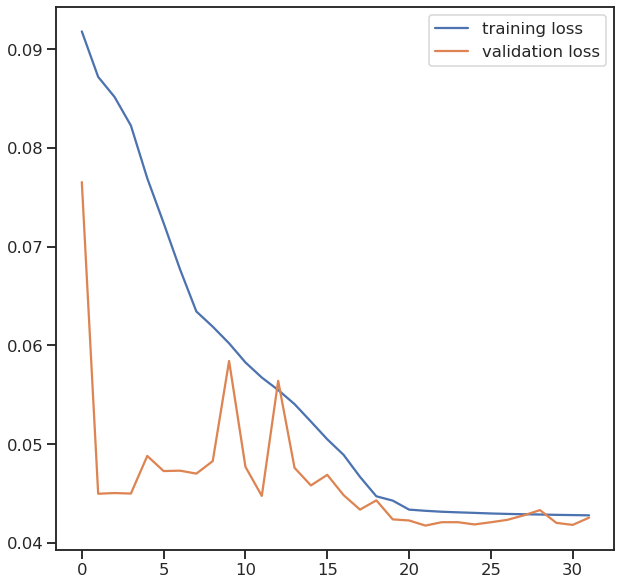

In [110]:
#Plot the training history
plot_training_history(path,logscale=False,jump_n_epochs=1)

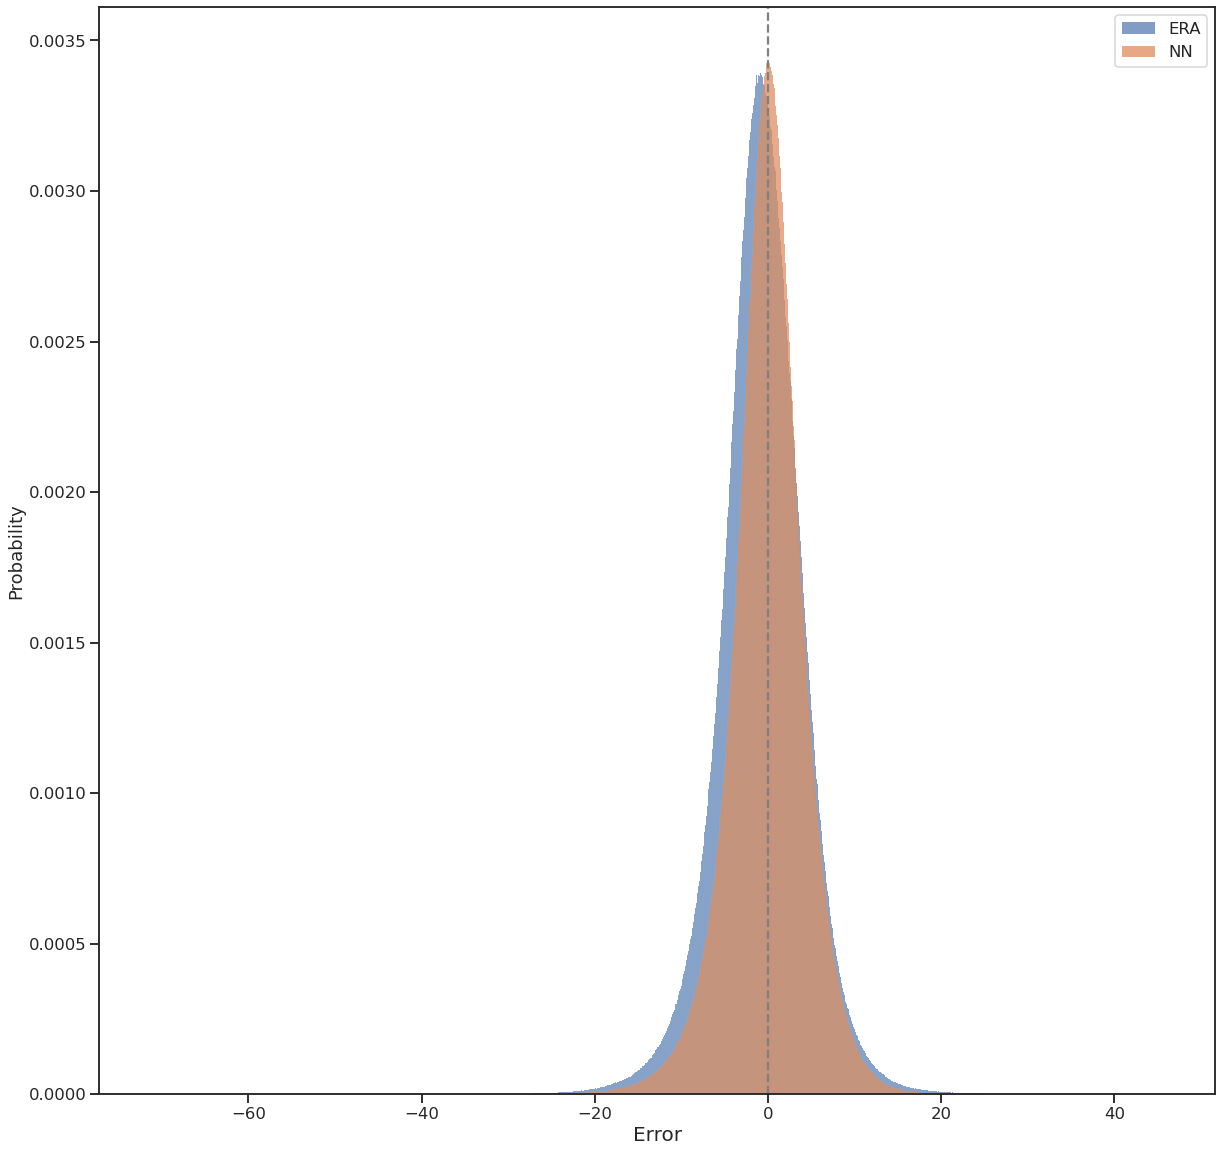

CPU times: user 1min 48s, sys: 6.42 s, total: 1min 54s
Wall time: 1min 53s


In [171]:
%%time

#Plot distribution of errors
#This is quite slow, ~1-2 mins

#Setup plot env
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )


#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))






sns.histplot(df['error_ERA'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0',label='ERA')
sns.histplot(df['error_NN'], bins='auto', stat='probability',kde=False,alpha=0.7,color='C1',label='NN')


# Config
ax1.set_xlabel('Error', fontsize = 20)
ax1.legend().set_title(None)
ax1.axvline(0,c='0.5', linestyle='--')




plt.show()



In [111]:
#Group by lat/long i.e. average over time
df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()


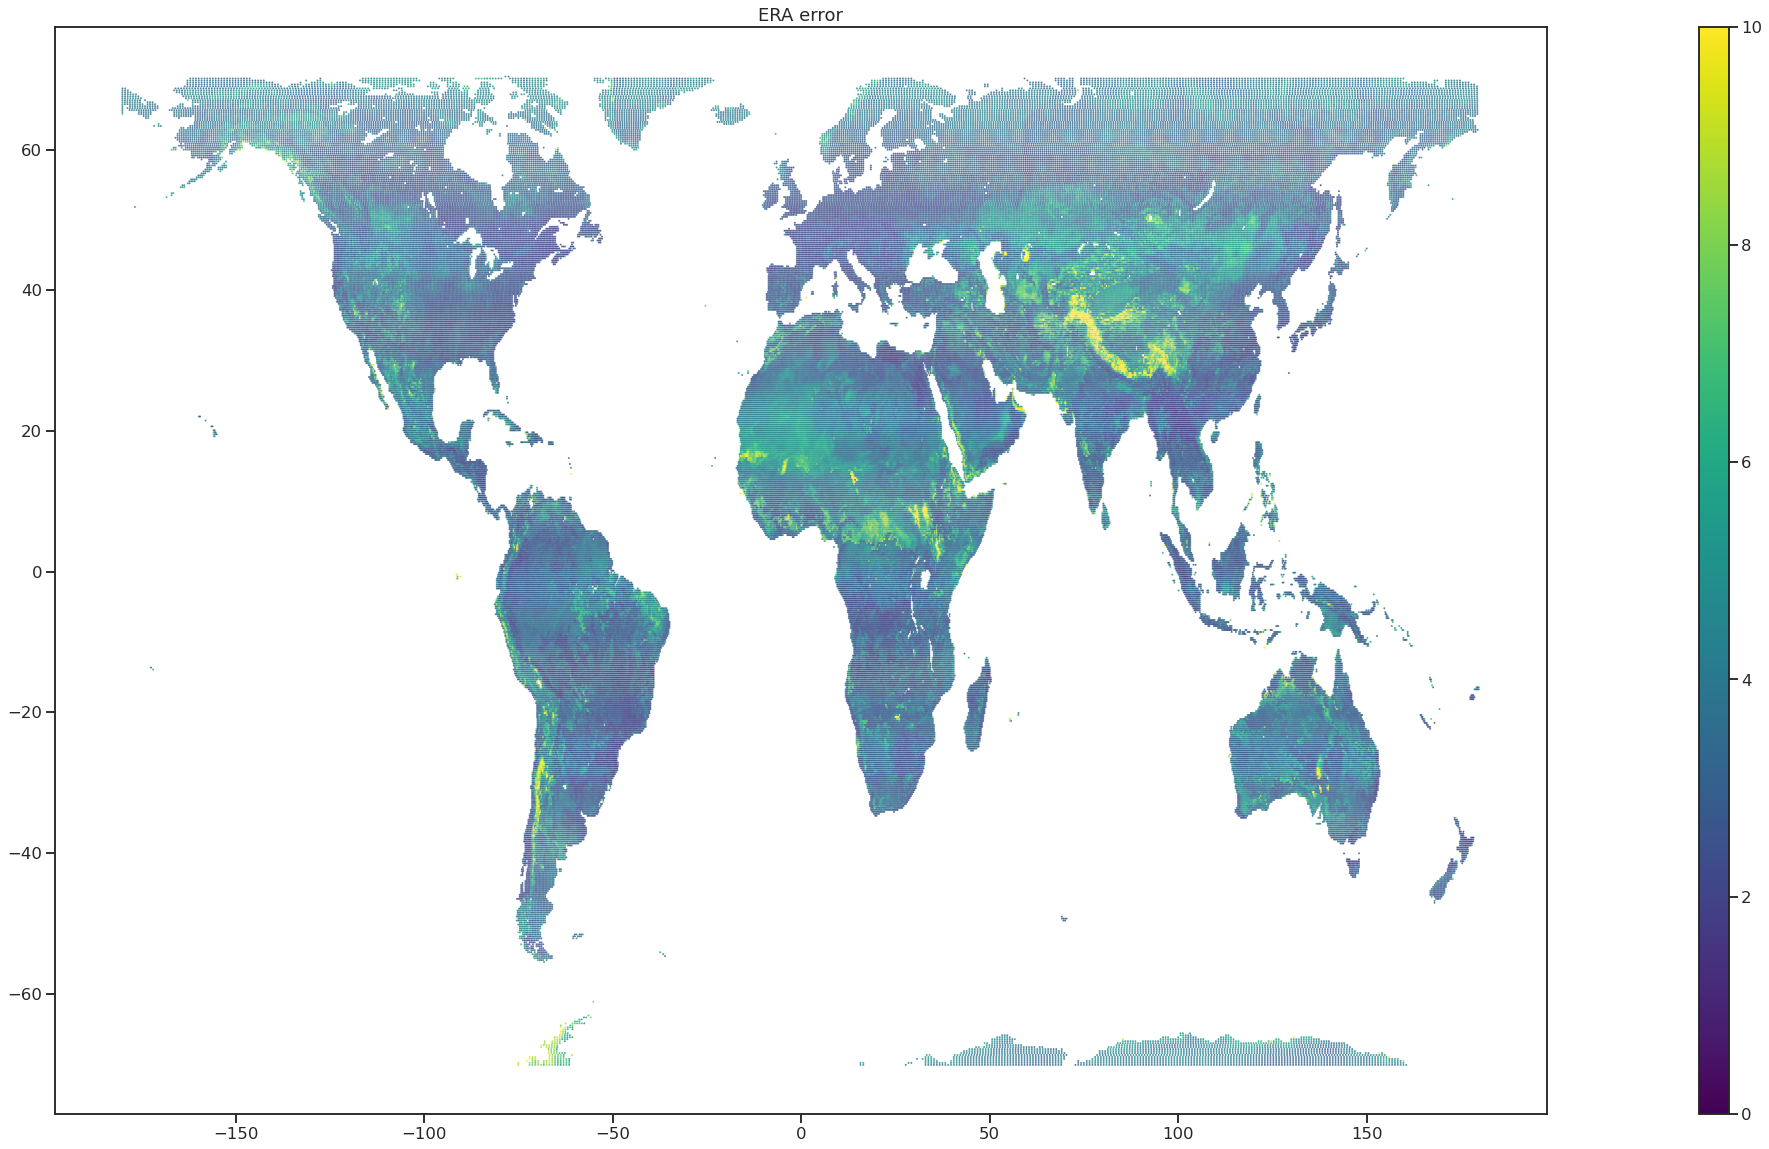

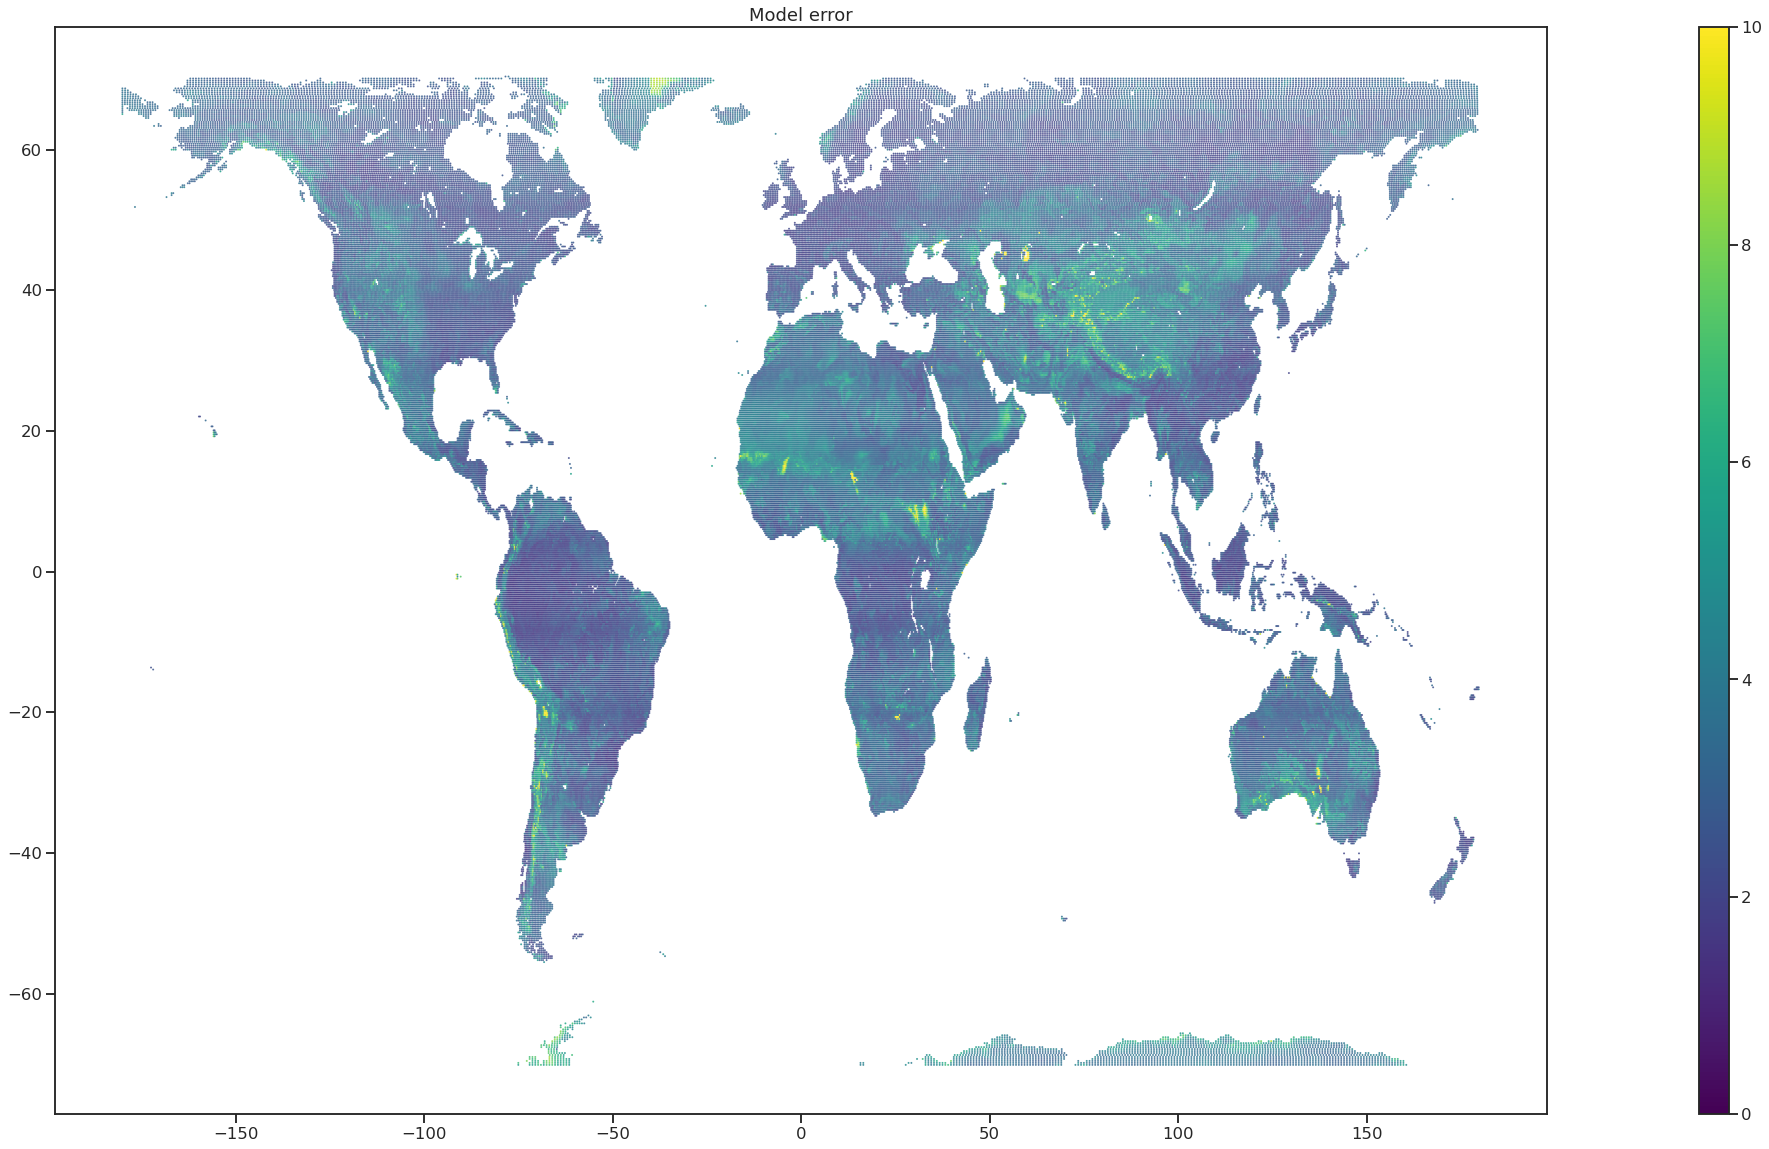

In [170]:
plot_error_map(df_grouped,'error_ERA_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,scale=None, title='ERA error')
plot_error_map(df_grouped,'error_NN_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,scale=None, title= 'Model error')

So in this example we can see that the trained model is typically better than the ERA SKT predictions

# 4.1 Compare models: V15 vs V20 <a name="analysiscompare"></a>

As described in  [ERA5 data](#rawdataERA5), we have two sets of constant in time climate data `v15` and `v20`.

**Q: does the v20 data make our model predictions better?**

In [174]:
def compare_models(model_1,model_1_label, 
                   model_2,model_2_label):
    
    
    
    #Model 1
    df1 = load_predictions(models_root+model_1,print_errors=False)
    df1_grouped = df1.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()


    #Model 2
    df2 = load_predictions(models_root+model_2,print_errors=False)
    df2_grouped = df2.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
    
    
    
    #Plot training history for interest
    plot_training_history(models_root+modelV15,logscale=False,jump_n_epochs=10)
    plot_training_history(models_root+modelV20,logscale=False,jump_n_epochs=10)
    
    
    #Plot error maps
    plot_error_map(df1_grouped,'error_NN_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,scale=None, title=model_1_label)
    plot_error_map(df2_grouped,'error_NN_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,scale=None, title=model_2_label)
    
    #Get the difference: model_1 - model 2
    dfjoined = pd.merge(df1_grouped, df2_grouped, on=['latitude_ERA', 'longitude_ERA'],suffixes=('_1', '_2') )
    
    dfjoined['delta'] = dfjoined['error_NN_abs_1'] - dfjoined['error_NN_abs_2']
    plot_error_map(dfjoined,'delta',vmin=-1,vmax=1,cmap=plt.cm.bwr,scale=None,title='Error 1 - Error 2')
    
    
    
    return df1,df1_grouped, df2, df2_grouped
    


input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/v15/all_months.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 50
 batch_size: 1024

input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/v20/all_months.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 50
 batch_size: 1024



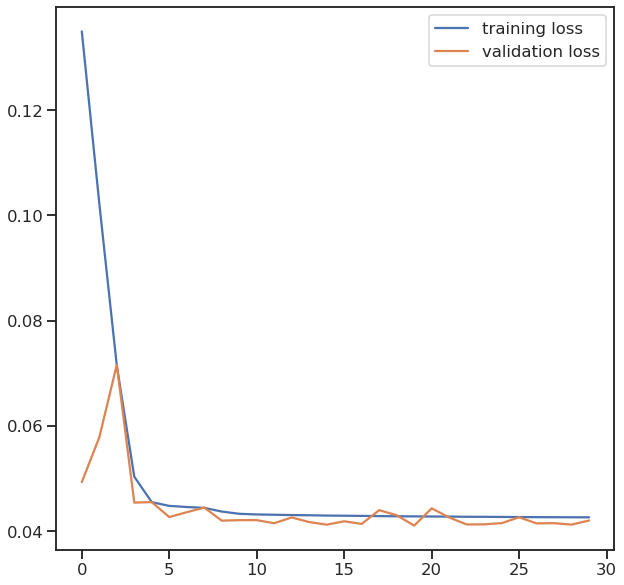

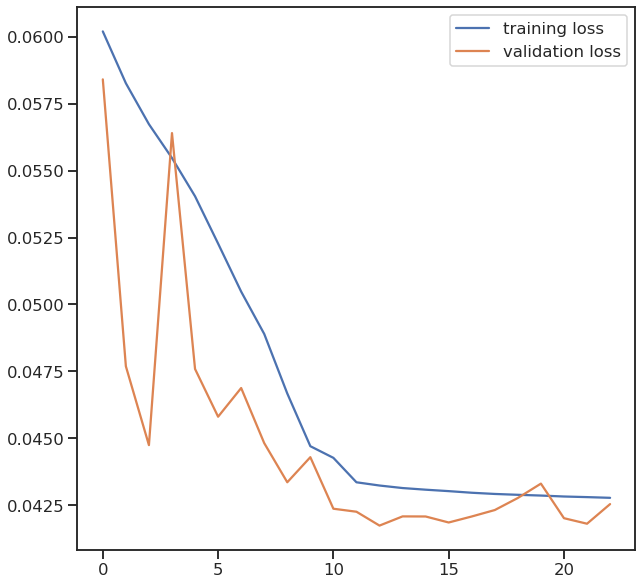

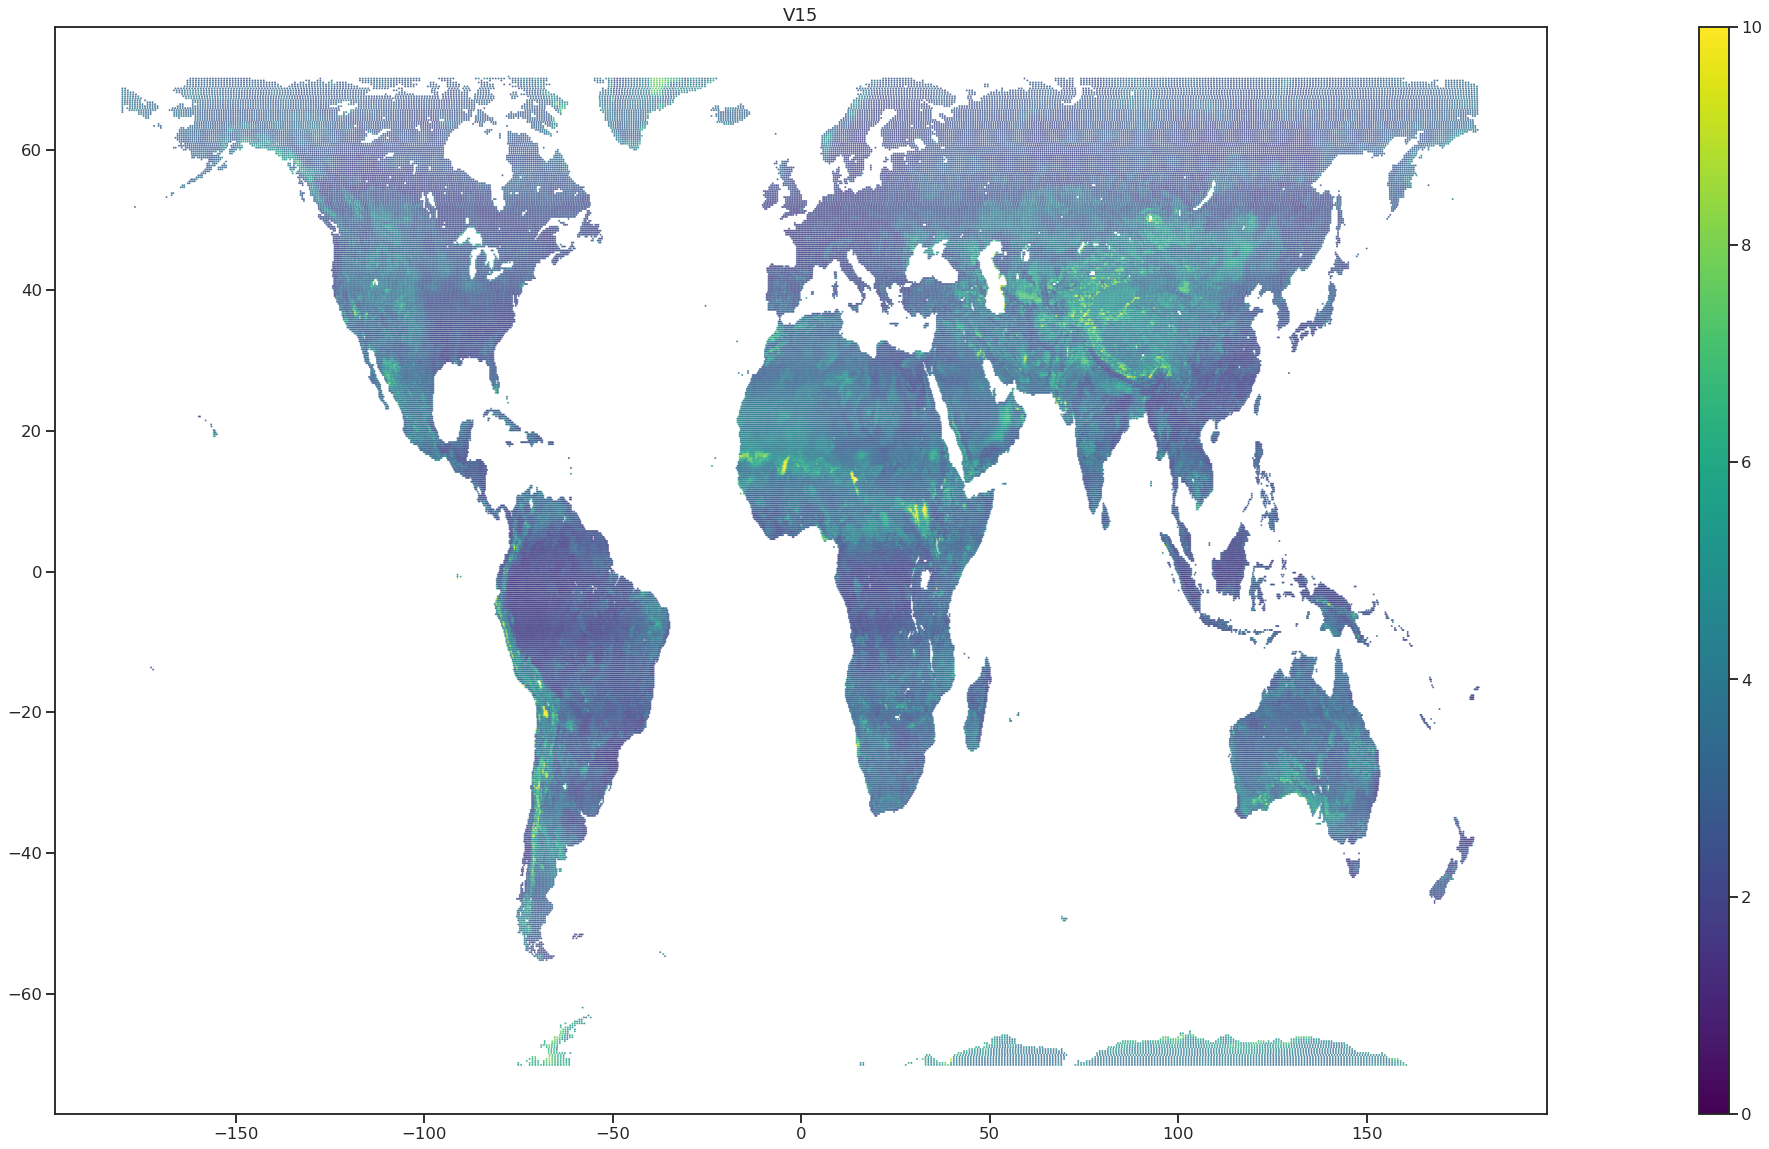

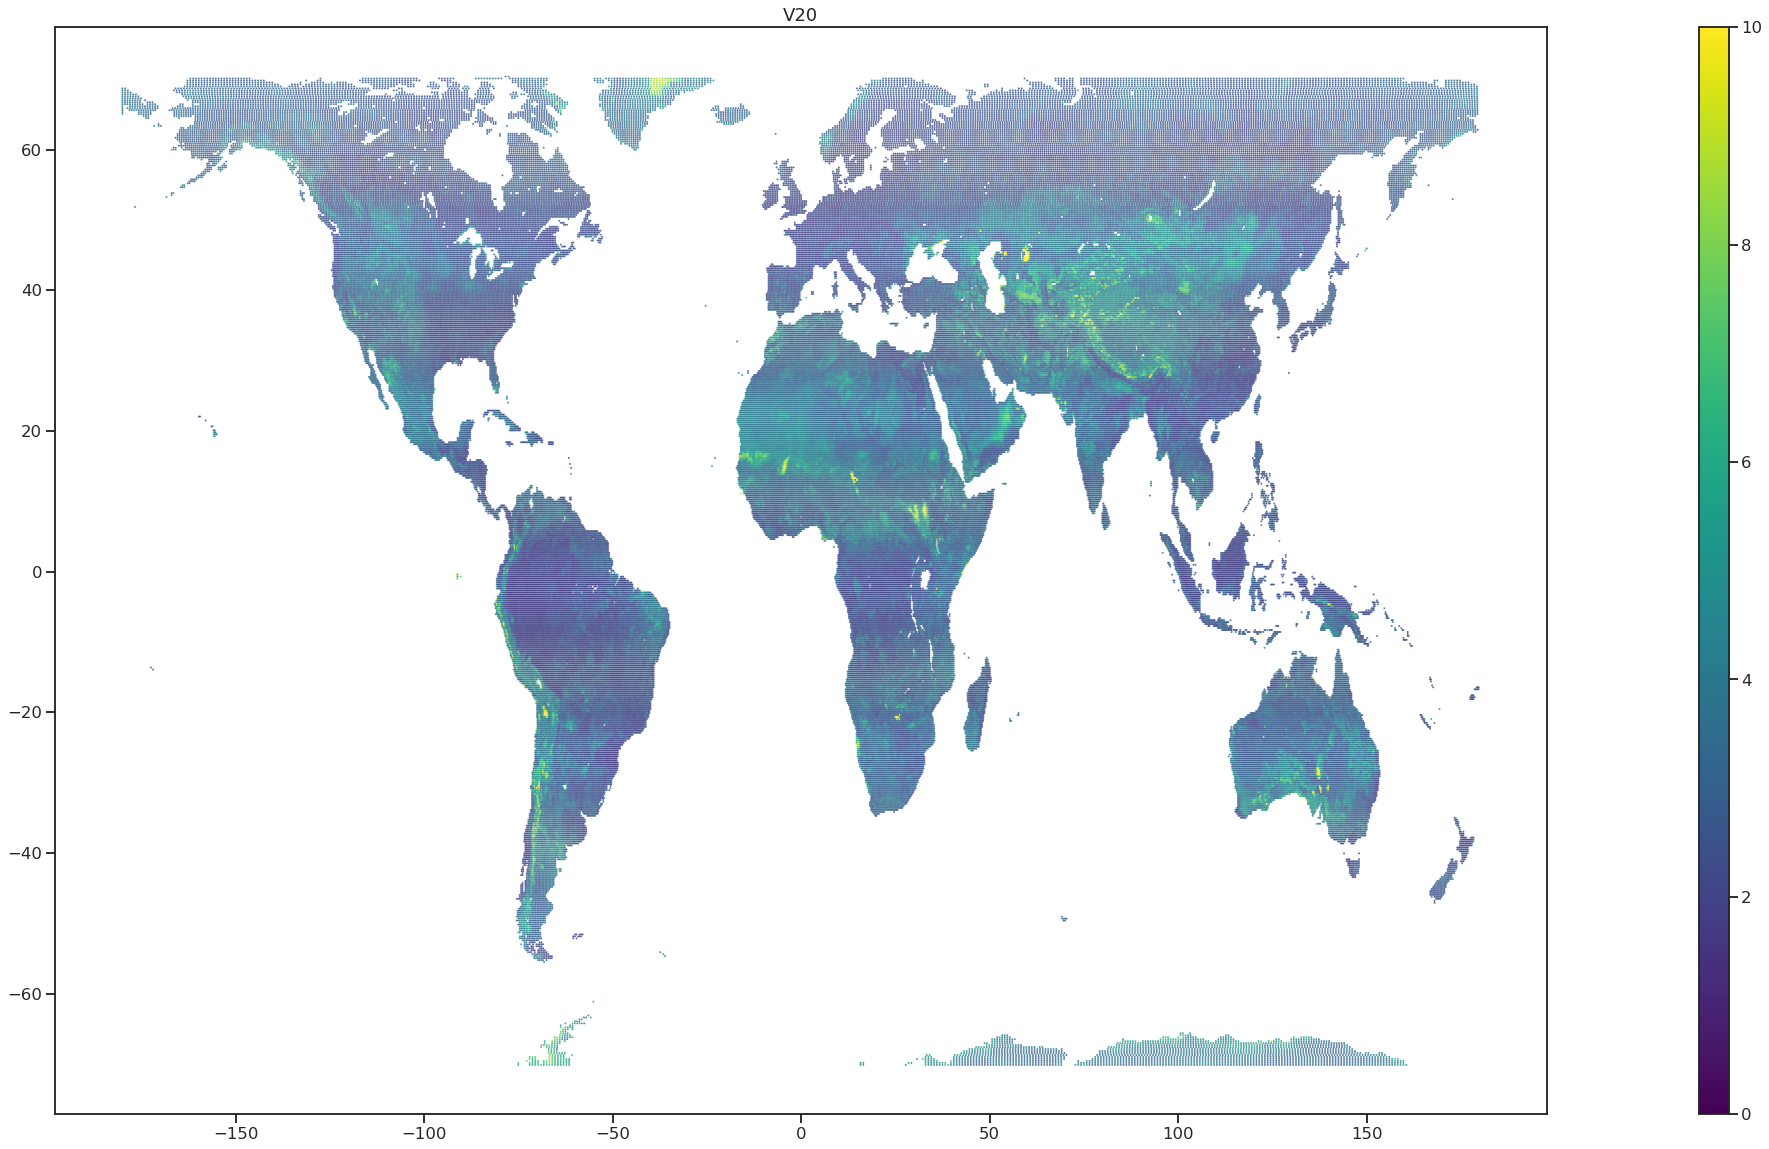

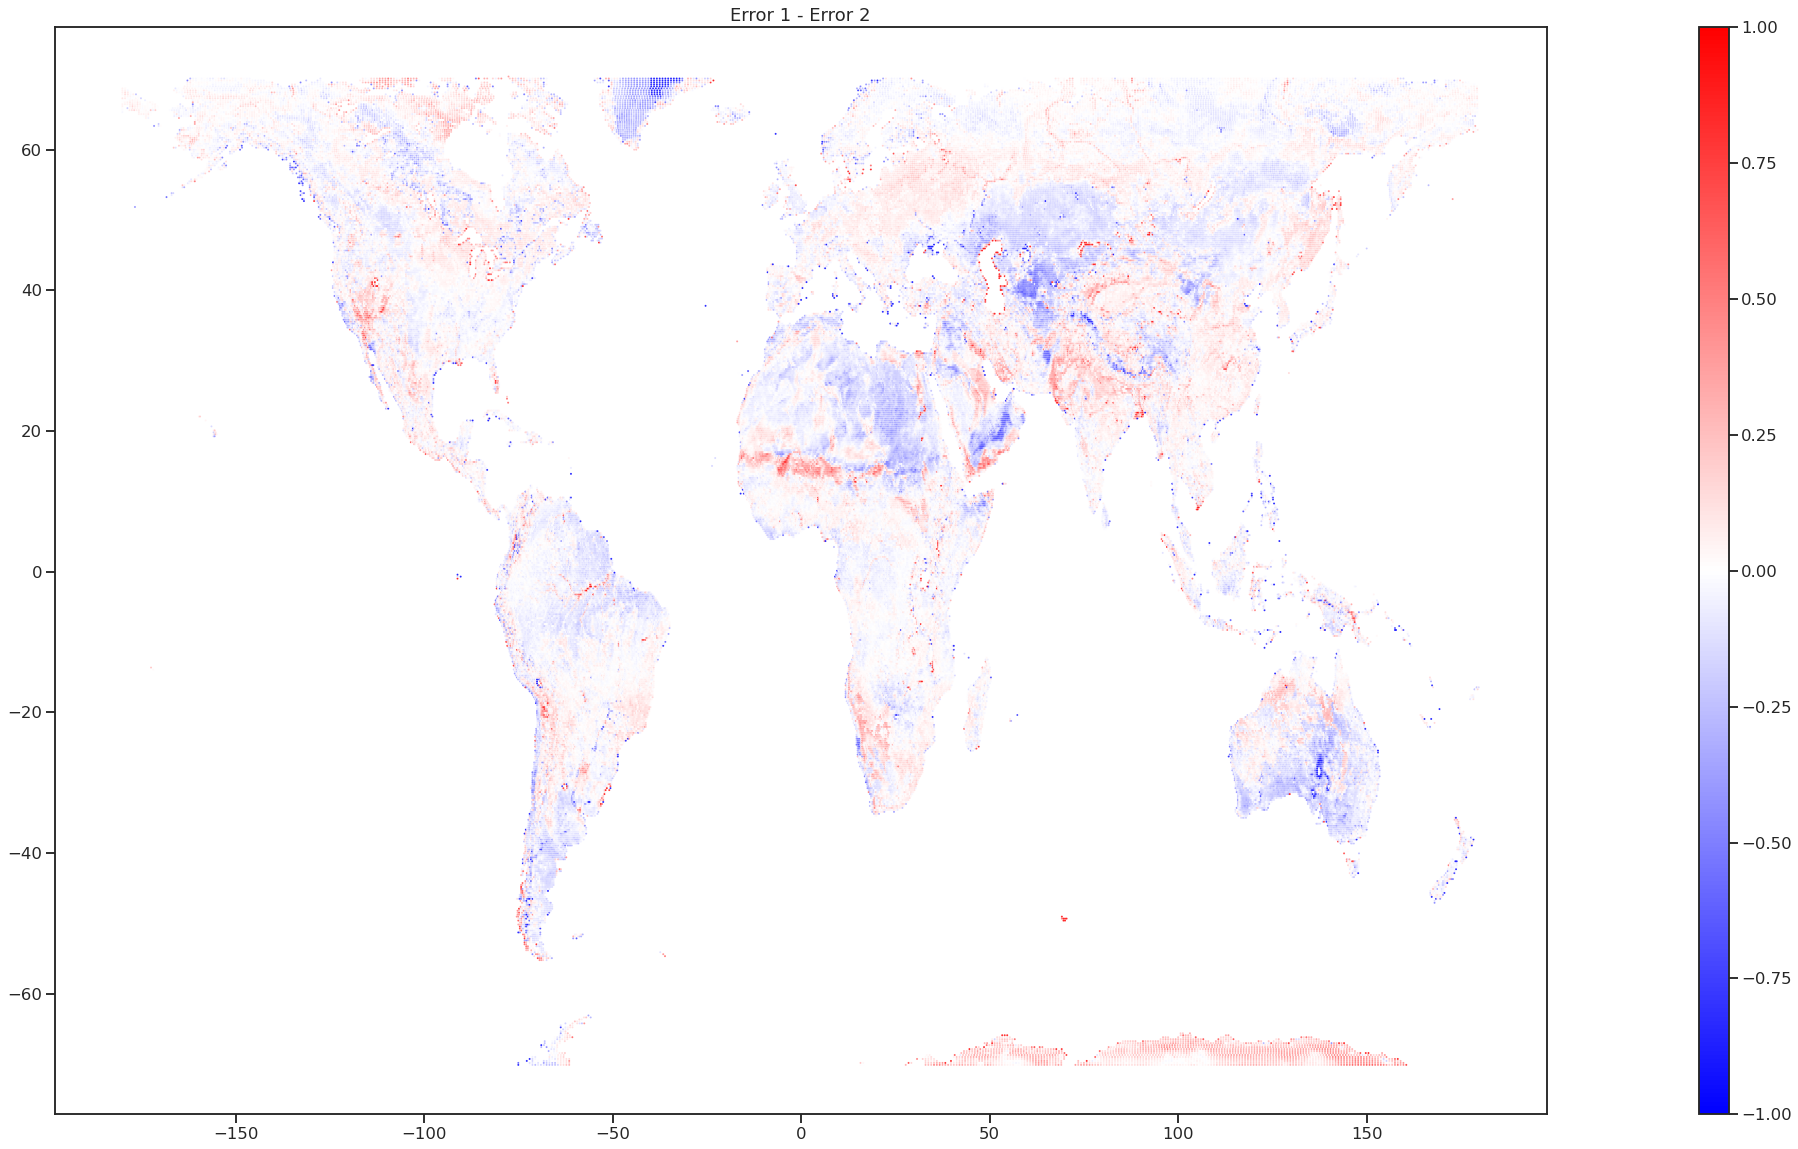

In [176]:

modelV15 = 'ML_8ba05663c6504c3995f3ca1fa1471f4e/'
modelV20 = 'ML_b6f1b47c51ad4b6c8f05748ea9f55fd2/'
    
df1,df1_grouped, df2, df2_grouped = compare_models(modelV15, 'V15',
                                                   modelV20, 'V20')



We can see that the predictions are fairly similar, whether we use v20 or v15

Reds = Error in v15 prediction greater than error in v20 prediction
Blues = Error in v15 prediction less than error in v20 prediction

# APPENDIX

In [ ]:
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_79851fcdfaa1421bb833e7e9fc8170fa/' #Original
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_61e4609f079c4ea0a7879b3cd1592be3/' #Original + validation
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_f8ea0e84bb304d2fa2a93eda74695e8c/'  #New features(v15), no validation
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/ML_a76e2887bb904f5bbb9462b8ea09457e/'  #Original features, v20, no validation



#Trained models
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'

#All features
#model = 'ML_acc386a38f1d481da481cf2bffb5bfba/'


#V20 climatological , no bonus features, 50 epochs, 1024 batch size, no validation data
#model = 'ML_2105750665c042e48729a3dbf5daefad/'
#As above, using validation data
model='ML_b6f1b47c51ad4b6c8f05748ea9f55fd2/'



#V15 climatological , no bonus features, 50 epochs, 1024 batch size, no validation data


#As above, using validation data
#model='ML_8ba05663c6504c3995f3ca1fa1471f4e/'

path = models_root+model
df = load_predictions(path)